# Physics Informed Neural Networks (PINNs) for 1D Heat Equation

## 1. Introduction
In this workbook, we would be training a physics informed neural network model for 1D Heat equation. In specific, we will solve:

$\frac{\partial{u}}{\partial{t}} - \nu\nabla^{2} u(x) = f(x,t)$, where $x \in [-1,1]$, and $t \in (0,1]$


We will use the concept of PINNs, where the input to the neural network is $x, t$ and the output of the network is $u(x,t)$. Loss function is evaluated by enforcing the PDE and the boundary conditions.

Physics informed neural networks is made of a dense neural network that takes in the $(x,t)$ points in the domain and learns the physics from it using PDEs such as the one just above. 

The architecture of the network looks something like this:

![](https://www.researchgate.net/profile/Zhen-Li-105/publication/335990167/figure/fig1/AS:806502679982080@1569296631121/Schematic-of-a-physics-informed-neural-network-PINN-where-the-loss-function-of-PINN.ppm)

We will use the concept of PINNs, where the input to the neural network is $(x, t)$ and the output of the network is $u(x,t)$. Loss function is evaluated by enforcing the PDE and the boundary conditions.

We will begin the workbook with few imports and creating some helper functions

## 2. Imports and helper functions

* **deepxde**    - library for solving forward and inverse problems using PINNs
* **numpy**      - library for working multi-dimensional arrays and matrices
* **matplotlib** - library for data visualization

In [1]:
import os
import deepxde as dde
import numpy as np
# Backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
import time 
import matplotlib.pyplot as plt
t0 = time.time()

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

import mlflow
import shutil
import tempfile

Using backend: tensorflow.compat.v1

2021-11-15 03:26:03.225209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-15 03:26:03.225246: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term



## MLflow for experiment tracking and model deployment

MLflow is an open source platform for managing the end-to-end machine learning lifecycle. It tackles four primary functions:

- Tracking experiments to record and compare parameters and results (MLflow Tracking).
- Managing and deploying models from a variety of ML libraries to a variety of model serving and inference platforms (MLflow Models).
- Providing a central model store to collaboratively manage the full lifecycle of an MLflow Model, including model versioning, stage transitions, and annotations (MLflow Model Registry).

More information [here](https://www.mlflow.org/docs/latest/index.html#)



![image.png](https://www.mlflow.org/docs/latest/_images/scenario_4.png)

- localhost maps to the server on which the current notebook is running

- Tracking server maps to the server at environment variable `TRACKING_URL` that can be printed using `os.environ.get("TRACKING_URL")`

- Create an mlflow client that communicates with the tracking server

In [2]:
from mlflow import pyfunc

# Setting a tracking uri to log the mlflow logs in a particular location tracked by 
from mlflow.tracking import MlflowClient
tracking_uri = os.environ.get("TRACKING_URL")
client = MlflowClient(tracking_uri=tracking_uri)
mlflow.set_tracking_uri(tracking_uri)

## Create an experiment in mlflow database using mlflow client

- Get the list of all the experiments (Click on **Experiments** tab on the sidebar to see the list)
- Create a new experiment named *numpy_deployment* if it doesn't exist
- Set *numpy_deployment* as the new experiment under which different **runs** are tracked

## MLflow Entity Hierarchy

- Experiment 1
    - Run 1
        - Parameters
        - Metrics
        - Artifacts
            - Folder 1
                - File 1
                - File 2
            - Folder 2 
    - Run 2
    - Run 3

- Experiment 2
- Experiment 3        

In [3]:
# Setting a tracking project experiment name to keep the experiments organized
experiments = client.list_experiments()
experiment_names = []
for exp in experiments:
    experiment_names.append(exp.name)
experiment_name = "pinn_deployment"
if experiment_name not in experiment_names:
    mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)


## Python Class for inference

- ModelWrapper is derived from mlflow.pyfunc.PythonModel [more info](https://www.mlflow.org/docs/latest/python_api/mlflow.pyfunc.html)
- load_context() member function is used to load the model. In this case, it loads a keras trained model which can be loaded.
- predict member function takes a numpy array as input and outputs another numpy array
- An object of this class will be saved as a pickle file in blob storage

In [4]:
## Model Wrapper that takes 
class ModelWrapper(mlflow.pyfunc.PythonModel):
    def load_context(self,context):
        import numpy as np
        import tensorflow as tf
        import deepxde as dde
        
        def pde(x, y):
            dy_t = dde.grad.jacobian(y, x, j=1)
            dy_xx = dde.grad.hessian(y, x, j=0)

            return (
                dy_t
                - dy_xx*0.3)


        def func(x):
            return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])

        geom = dde.geometry.Interval(-1, 1)
        timedomain = dde.geometry.TimeDomain(0, 1)
        geomtime = dde.geometry.GeometryXTime(geom, timedomain)
        bc = dde.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
        ic = dde.IC(geomtime, func, lambda _, on_initial: on_initial)
        data = dde.data.TimePDE(
            geomtime,
            pde,
            [bc, ic],
            num_domain=1,
            num_boundary=1,
            num_initial=1,
            solution=func,
            num_test=1,
        )
        layer_size = [2] + [32] * 3 + [1]
        activation = "tanh"
        initializer = "Glorot uniform"
        net = dde.maps.FNN(layer_size, activation, initializer)
        model = dde.Model(data, net)
        model.compile("adam", lr=0.001, metrics=["l2 relative error"])
        model.restore(context.artifacts["model_path"]+'/model-100')
        self.model = model
        print("Model initialized")
    
    def predict(self, context, model_input):
        import numpy as np
        import pandas as pd
        import json
        data_list = model_input.values
        inputs = np.array(data_list)
        if len(inputs.shape) == 2:
            print('batch inference')
            predictions = self.model.predict(inputs)
            predictions = predictions.tolist()
        elif len(inputs.shape) == 1:
            print('single inference')
            predictions = self.model.predict(np.expand_dims(inputs,0))
            predictions = predictions.tolist()
        else:
            raise ValueError('invalid input shape')
        return json.dumps(predictions)

## Helper function to plot $u(x,t)$

In [5]:
def plot(geom_time,data,name):
    plt.figure()
    plt.scatter(geom_time[:,0], geom_time[:,1],s = 20, c=np.reshape(data, (len(data),)), cmap='jet')
    plt.colorbar()
    plt.xlabel('x domain')
    plt.ylabel('time domain')
    plt.title(name)
    plt.show()

## Functions used to calcuate neural network loss

PDE: $pde(x,y) : \frac{\partial{u}}{\partial{t}} - \nu\nabla^{2} u(x) =0$, where $\nu = 0.3$ 

Boundary conditions $func(x): \sin(\pi x)e^{x}$

Deepxde provides help functions to compute first and second derivatives

_dde.grad.jacobian_ is used to compute Jacobian matrix $J: J[i][j] = \frac{dy_i}{dx_j}$, where $i,j=0,…,dim_x-1$

_dde.grad.Hessian_ is used to compute Hessian matrix $H: H[i][j] = \frac{d^2y}{dx_i dx_j}$, where $i,j=0,…,dim_x-1$

In [6]:
# define the PDE for 1D Heat equations
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x, j=0)

    return (
        dy_t
        - dy_xx*0.3)
    

def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])

## 2. model instantiation
Define the model for training PINN

In [7]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
bc = dde.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, func, lambda _, on_initial: on_initial)
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=4000,
    num_boundary=2000,
    num_initial=1000,
    solution=func,
    num_test=1000,
)
layer_size = [2] + [32] * 3 + [1]

activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

Compiling model...
Building feed-forward neural network...
'build' took 0.046276 s



2021-11-15 03:26:07.067776: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-15 03:26:07.067810: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-15 03:26:07.067849: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (knrphwgg-6889997f5d-w24t4): /proc/driver/nvidia/version does not exist
2021-11-15 03:26:07.068181: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'compile' took 0.355327 s



## 3. Training


In [8]:
t1 = time.time()

epochs = 100
losshistory, train_state = model.train(epochs=epochs)

t2 = time.time()
print("training time:",(t2-t1))

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [5.40e-02, 2.94e-02, 6.05e-01]    [5.36e-02, 2.94e-02, 6.05e-01]    [1.16e+00]    
100       [9.40e-03, 5.65e-02, 3.05e-01]    [7.33e-03, 5.65e-02, 3.05e-01]    [8.69e-01]    

Best model at step 100:
  train loss: 3.71e-01
  test loss: 3.69e-01
  test metric: [8.69e-01]

'train' took 4.916609 s

training time: 4.917330980300903


## 4. Model Deployment

## Register a model using mlflow

- Log user-defined parameters in a remote database through a remote server
- Create a model_wrapper object using ModelWrapper() class in the above cell
- Create a default conda environment that need to be installed on the Docker conatiner that serves a REST API
- Save the model object as a pickle file and conda environment as artifacts (files) in S3 or Blob Storage

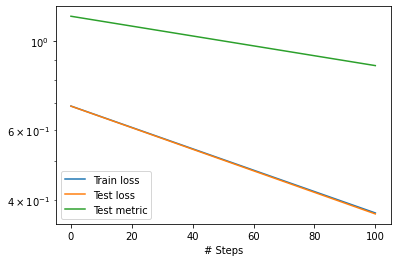

INFO:tensorflow:./pinn1d/model-100 is not in all_model_checkpoint_paths. Manually adding it.


In [9]:
dde.postprocessing.plot_loss_history(losshistory)
plt.show()


## Utility function to add libraries to conda environment
def add_libraries_to_conda_env(_conda_env,libraries=[],conda_dependencies=[]):
    dependencies = _conda_env["dependencies"]
    dependencies = dependencies + conda_dependencies
    pip_index = None
    for _index,_element in enumerate(dependencies):
        if type(_element) == dict:
            if "pip" in _element.keys():
                pip_index = _index
                break
    dependencies[pip_index]["pip"] =  dependencies[pip_index]["pip"] + libraries
    _conda_env["dependencies"] = dependencies
    return _conda_env

# checkpointing and logging the model in mlflow
model_wrapper = ModelWrapper()
artifact_path = './pinn1d/model'
model.save(artifact_path)
model_artifacts = {"model_path" : os.path.split(artifact_path)[0]}
env = mlflow.tensorflow.get_default_conda_env()
env = add_libraries_to_conda_env(env,libraries=['deepxde'])

with mlflow.start_run():
    mlflow.log_param("epochs",epochs)
    mlflow.pyfunc.log_model("pinn_model", python_model=model_wrapper, artifacts=model_artifacts, conda_env=env)

## 4. Deploying the model
The above code logs a model in the experiments tab. For more info please refer [here](https://rocketml.gitbook.io/rocketml-user-guide/experiments). 

### 4.1 Find experiment in experiment list and click on it
![experiments_list](https://github.com/rocketmlhq/sciml/raw/e8abbef269c5bee9d2b69398495fc5ced7457708/03_Deployment/experiments_list.png)

### 4.2 Find run in runs list and click on it
![runs_list](https://github.com/rocketmlhq/sciml/raw/e8abbef269c5bee9d2b69398495fc5ced7457708/03_Deployment/runs_list.png)

### 4.3 Get run details and click on artifacts
![run_details](https://github.com/rocketmlhq/sciml/raw/e8abbef269c5bee9d2b69398495fc5ced7457708/03_Deployment/run_details.png)

### 4.4 Check different files logged as artifacts
![artifacts](https://github.com/rocketmlhq/sciml/raw/e8abbef269c5bee9d2b69398495fc5ced7457708/03_Deployment/artifacts.png)

- An MLflow Model is a standard format for packaging machine learning models that can be used in a variety of downstream tools [More Details](https://www.mlflow.org/docs/latest/models.html#storage-format)
- ModelWrapper() object is saved as pkl file
- conda.yaml and requirements.txt file are used to manage Python environment
- Numpy file is saved in artifacts folder within the main folder (np_model)

### 4.5 Deploy ML model as a REST API service

Click on **Convert To Model** and fill the form. **Note: For deploying the PINN model, please select atleast 4096 memory for deployment**

![model_deployment](https://github.com/rocketmlhq/sciml/raw/e8abbef269c5bee9d2b69398495fc5ced7457708/03_Deployment/model_deployment.png)

### 4.6 Go to models tab and wait until the model turns to **ON** state
![model_list](https://github.com/rocketmlhq/sciml/raw/e8abbef269c5bee9d2b69398495fc5ced7457708/03_Deployment/model_list.png)

## 5. Use the Endpoint and Query from the server

There are two methods to perform query... The first is using `requests` library and the other using `curl` shell command.

In [65]:
import requests
import json

################################################################################
# *** SET MODEL URL HERE BEFORE RUNNING THIS CELL (instructions above) ***
# Example: https://<random_string>.sciml.rocketml.net/invocations
url = ""
################################################################################

if not url:
    raise ValueError('Model URL not set! Please read instructions on how to deploy model, set the correct URL, and try again.')

headers = {"Content-Type":"application/json; format=pandas-split"}

# First case, run inference on single data point
x_data = np.linspace(-1,1,num = 100)
t_data = np.linspace(0,1,num = 100)
test_x , test_t = np.meshgrid(x_data, t_data)
test_domain = np.vstack((np.ravel(test_x), np.ravel(test_t))).T
# json_data = json.dumps(test_domain.tolist())
import pandas as pd
json_data = pd.DataFrame(test_domain, columns=['xx','tt']).to_json(orient='split')

if url:
    response = requests.post(url,data=json_data,headers=headers)
    if response.status_code == 200:
        output = np.array(json.loads(response.json())).astype(np.float32)
        print(output)
    else:
        print(response.status_code)
        print("REST API deployment is in progress -- please try again in a few minutes!")
else:
    print("Make sure that the model is in ON state. Copy the Endpoint")

[[-0.30753154]
 [-0.31334445]
 [-0.3189779 ]
 ...
 [ 0.0614724 ]
 [ 0.05806611]
 [ 0.05459545]]


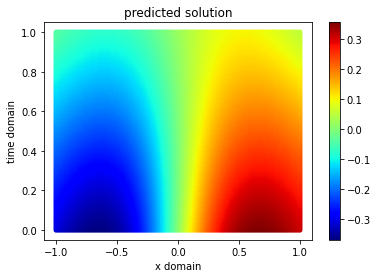

In [67]:
plot(test_domain,output,"predicted solution")